In [1]:
from fastai2.vision.all import *
from fastai2.vision.learner import _default_meta, _add_norm, _update_first_layer
from torch.utils.checkpoint import checkpoint, checkpoint_sequential
from knockknock import email_sender

In [2]:
root_dir = Path('/')
data_dir = root_dir / 'data' / 'chest_xray'
model_dir = Path('.').absolute() / 'models'

In [3]:
sz = 256
lr = defaults.lr
bs = 64 * 2
stats = ([0.48746821, 0.48746821, 0.48746821], [0.24557937, 0.24557937, 0.24557937])

In [4]:
def valid_func(o: Path):
    return 'test' in str(o)

def label_func(o: Path):
    if 'virus' in o.name:
        return 'pneumonia'
    if 'bacteria' in o.name:
        return 'pneumonia'
    return 'normal'

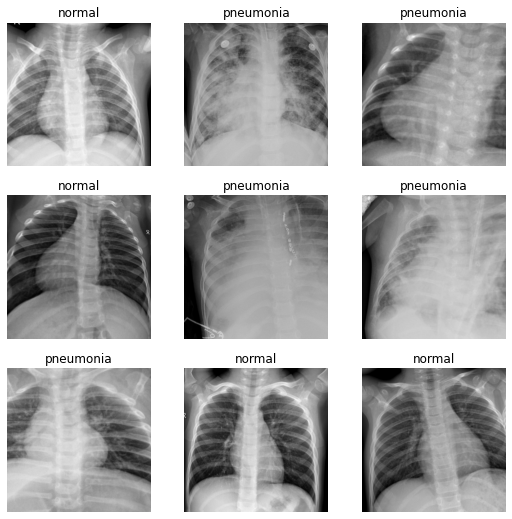

In [5]:
db = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=FuncSplitter(valid_func),
                 get_y=label_func,
                 item_tfms=Resize(sz*2),
                 batch_tfms=[*aug_transforms(size=sz), Normalize.from_stats(*stats)])

data = db.dataloaders(data_dir, bs=bs)
data.show_batch(max_n=9)

In [6]:
resnet101(True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
class CkptSequential(nn.Module):
    def __init__(self, module, num_segments=1):
        super().__init__()
        assert num_segments == 1 or isinstance(module, nn.Sequential)
        self.module = module
        self.num_segments = num_segments

    def forward(self, *inputs):
        if self.num_segments > 1:
            return checkpoint_sequential(self.module, self.num_segments, *inputs)
        else:
            return checkpoint(self.module, *inputs)

In [8]:
resnet_layers = {
    resnet18 :[2, 2, 2, 2], 
    resnet34 :[3, 4, 6, 3],
    resnet50 :[3, 4, 6, 3], 
    resnet101:[3, 4, 23, 3],
    resnet152:[3, 8, 36, 3],
}

ckpt_segments = 4 # since 4x4 < 23 < 5x5

def create_body_ckpt(arch, n_in=3, pretrained=True, cut=None):
    "Cut off the body of a typically pretrained `arch` as determined by `cut`"
    model = arch(pretrained=pretrained)
    _update_first_layer(model, n_in, pretrained)
    #cut = ifnone(cut, cnn_config(arch)['cut'])
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int):
        if (arch.__name__).find("resnet")==0:
            layers = resnet_layers[arch]
            out = nn.Sequential(*list(model.children())[:4], # conv1-bn1-relu-maxpool at the beginning with no sequential
                                *[CkptSequential(x, min(ckpt_segments, layers[i])) for i, x in enumerate(list(model.children())[:cut][4:])])
        else:
            out = nn.Sequential(*list(model.children())[:cut])
        return out
    elif callable(cut): return cut(model)
    else:                           raise NamedError("cut must be either integer or a function")

In [9]:
@delegates(create_head)
def create_cnn_model_ckpt(arch, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=True, **kwargs):
    "Create custom convnet architecture using `arch`, `n_in` and `n_out`"
    body = create_body_ckpt(arch, n_in, pretrained, cut)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model

In [10]:
@log_args(to_return=True, but_as=Learner.__init__)
@delegates(Learner.__init__)
def cnn_learner_ckpt(dls, arch, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch`"
    if config is None: config = {}
    meta = model_meta.get(arch, _default_meta)
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be infered from data, set `dls.c` or pass `n_out`"
    if normalize: _add_norm(dls, meta, pretrained)
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_cnn_model_ckpt(arch, n_out, ifnone(cut, meta['cut']), pretrained, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=ifnone(splitter, meta['split']), **kwargs)
    if pretrained: learn.freeze()
    return learn

In [11]:
learn = cnn_learner_ckpt(data,
                    resnet101,
                    metrics=error_rate,
                    bn_wd=False,
                    loss_func=LabelSmoothingCrossEntropy(),
                    cbs=[BnFreeze,
                          SaveModelCallback(monitor='error_rate', name='best_error'),
                          ShowGraphCallback,
                         ],
                    model_dir=model_dir,
                   ).to_fp16()

/opt/conda/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [12]:
@email_sender(recipient_emails=["yyang@hbku.edu.qa"], sender_email="hbkubot@gmail.com")
@delegates(learn.fit_one_cycle)
def train(learn, name, lr, n_epochs=5, **kwargs): # must be called kwargs, not kw_args or anything else
    learn.fit_one_cycle(n_epochs, lr, **kwargs)
    learn.save(name)

Password for <hbkubot@gmail.com>: ········
Save username and password in keyring? [y/n]: y


epoch,train_loss,valid_loss,error_rate,time
0,0.821977,0.666346,0.150641,00:30
1,0.553879,0.546322,0.179487,00:28
2,0.431957,0.428587,0.104167,00:28
3,0.367653,0.408049,0.100962,00:28
4,0.336313,0.407759,0.099359,00:28


Better model found at epoch 0 with error_rate value: 0.15064100921154022.


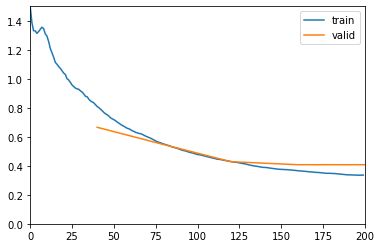

Better model found at epoch 2 with error_rate value: 0.1041666641831398.
Better model found at epoch 3 with error_rate value: 0.10096152871847153.
Better model found at epoch 4 with error_rate value: 0.09935897588729858.


In [13]:
train(learn, 'stage_1', lr)

SuggestedLRs(lr_min=3.981071586167673e-07, lr_steep=1.0964781722577754e-06)

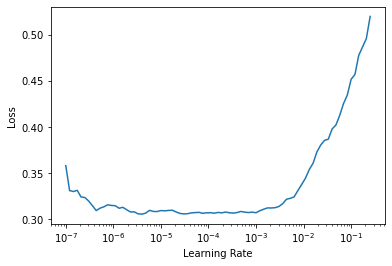

In [14]:
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time
0,0.308091,0.401231,0.099359,00:33
1,0.297220,0.465680,0.139423,00:33
2,0.287133,0.398380,0.102564,00:33
3,0.274586,0.390445,0.116987,00:33
4,0.264976,0.397128,0.115385,00:34


Better model found at epoch 0 with error_rate value: 0.09935896843671799.


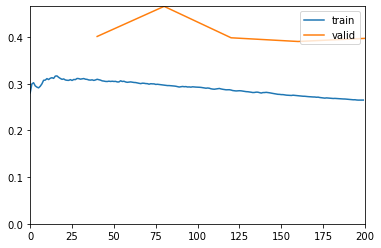

In [15]:
lr = 3e-4
train(learn, 'stage_2', slice(lr/100, lr))

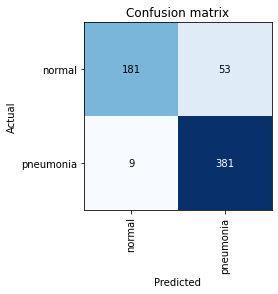

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()